## Assignment 4 

### Basic Settings 

In [1]:
# !pip install virtualenv

In [2]:
# conda install graphviz python-graphviz

In [3]:
# conda list graphviz

In [4]:
import graphviz

### Check the current working directory

In [5]:
import os

current_directory = os.getcwd()
print("Current working directory:", current_directory)

Current working directory: /Users/joonkyuhong/Desktop/GWU/python/RML


### Imports and inits

In [6]:
from sklearn.metrics import accuracy_score, f1_score  
from sklearn.metrics import roc_auc_score
import random
import datetime                                               # for timestamp 
import h2o  
from h2o.backend import H2OLocalServer 
from h2o.estimators.random_forest import H2ORandomForestEstimator
from h2o.estimators.glm import H2OGeneralizedLinearEstimator  # h2o elastic net models class
from h2o.grid.grid_search import H2OGridSearch                # grid search class and syntax for h2o models                                 # for cartesian product of parameters
import matplotlib.pyplot as plt                               # basic plotting
import numpy as np                                            # for basic array manipulation                            
import pandas as pd                                           # for dataframe manipulation
import seaborn as sns                                         # slightly better plotting  
import time                                                   # for timers
import xgboost as xgb                                             # base h2o package for python
import warnings                                                # remove warnings
import subprocess  
from sklearn.metrics import accuracy_score, f1_score  
from sklearn.metrics import roc_auc_score
import random
# enables display of images in notebook
from IPython.display import Image
from IPython.display import display
warnings.filterwarnings("ignore", message="The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.")
# set numpy random seed for better reproducibility
SEED = 12345 
np.random.seed(SEED)
# set number of threads
NTHREAD = 4

h2o.init(max_mem_size='2G')      # start h2o
h2o.remove_all()                 # remove any existing data structures from h2o memory
h2o.no_progress()                # turn off h2o progress indicators  

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,17 hours 32 mins
H2O_cluster_timezone:,America/New_York
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.40.0.4
H2O_cluster_version_age:,2 months and 3 days
H2O_cluster_name:,H2O_from_python_joonkyuhong_sn2gbx
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,5.928 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


### Define Utility Functions
#### Utility function that trains a cross-validated decision tree

In [7]:
def get_cv_dt(x_names, y_name, train, model_id, seed_, title, valid=None):

    """ Utility function to train decision trees.
    Args:
        x_names: Names of input variables as a list.
        y_name: Name of target variable.
        train: Pandas DataFrame containing x_names and y_name on which to train
               decision tree.
        model_id: h2o model identifier.
        seed_: Random seed for improved reproducibility.
        title: Title for generated plot of tree.
        valid: Optional validation data.
    Returns:
        Model as h2o model object.
    """

    # initialize single tree model
    tree = H2ORandomForestEstimator(ntrees=1,  # use only one tree
                                    sample_rate=1,  # use all rows in that tree
                                    mtries=-2,  # use all columns in that tree's split search
                                    max_depth=4,  # shallow trees are easier to understand
                                    seed=seed_,  # set random seed for reproducibility
                                    nfolds=3,  # cross-validation for stability and ...
                                    # only way to get metrics for 1 tree in h2o
                                    model_id=model_id)  # gives MOJO artifact a recognizable name

    # train single tree model
    if valid is not None:
        tree.train(x=x_names, y=y_name, training_frame=h2o.H2OFrame(train), validation_frame=h2o.H2OFrame(valid))
    else:
        tree.train(x=x_names, y=y_name, training_frame=h2o.H2OFrame(train))

    # persist MOJO (compiled Java representation of trained model)
    # from which to generate plot of tree
    mojo_path = tree.download_mojo(path='.')
    print('Generated MOJO path:\n', mojo_path)

    # generate graphviz file and then PNG
    get_gv(title, model_id, mojo_path)
    get_png(model_id)

    return tree


#### Utility function that converts h2o MOJO into graphviz file

In [8]:
def get_gv(title, model_id, mojo_path):

    """ Utility function to generate graphviz dot file from h2o MOJO using
        a subprocess.
       
    Args:
        title: Title for displayed decision tree.
        model_id: h2o model identifier.
        mojo_path: Path to saved model MOJO (Java scoring artifact);
                   generated by train_cv_dt function above.
    """

    # locate h2o jar
    hs = H2OLocalServer()
    h2o_jar_path = hs._find_jar()
    print('Discovered H2O jar path:\n', h2o_jar_path)

    # construct command line call to generate graphviz version of
    # tree, see for more information:
    # http://docs.h2o.ai/h2o/latest-stable/h2o-genmodel/javadoc/index.html
    gv_file_name = model_id + '.gv'
    # if the line below fails for you, try instead:
    #gv_args = str('-cp ' + h2o_jar_path +
    #              ' hex.genmodel.tools.PrintMojo --tree 0 -i "'
    #              + mojo_path + '" -o').split()
    gv_args = str('-cp ' + h2o_jar_path +
                  ' hex.genmodel.tools.PrintMojo --tree 0 -i '
                  + mojo_path + ' -o').split()
    gv_args.insert(0, 'java')
    gv_args.append(gv_file_name)
    if title is not None:
        gv_args = gv_args + ['--title', '"' + str(title) + '"']

    # call constructed command
    print()
    print('Calling external process ...')
    print(' '.join(gv_args))
    # if the line below is failing for you, try instead:
    # _ = subprocess.call(gv_args, shell=True)
    _ = subprocess.call(gv_args)

#### Utility function that converts graphviz file into PNG

- Change the code from the example.

In [9]:
def get_png(model_id):
    """Utility function to generate PNGs from .dots using Graphviz library.
    Args:
        model_id: h2o model identifier.
    """
    gv_file_name = model_id + '.gv'
    png_file_path = '/Users/joonkyuhong/Desktop/GWU/python/RML' + model_id + '.png'  
    try:
        graph = graphviz.Source.from_file(gv_file_name)
        graph.format = 'png'
        graph.render(filename=png_file_path, cleanup=True, engine='dot', format='png', quiet=False)
        print(f"PNG file '{png_file_path}' generated successfully.")
    except FileNotFoundError:
        print(f"Failed to generate PNG file. '{gv_file_name}' not found.")



### Start global timer

In [10]:
tic = time.time()

### import data

In [11]:
data = pd.read_csv('hmda_train_preprocessed.csv')

In [12]:
y_name = 'high_priced'

### Fit interpretable model
#### Split data into train and validation partitions

In [13]:
np.random.seed(SEED) # preserve exact reproducibility for this cell

split_ratio = 0.7 # 70%/30% train/test split

# execute split
split = np.random.rand(len(data)) < split_ratio
train = data[split]
valid = data[~split]

# summarize split
print('Train data rows = %d, columns = %d' % (train.shape[0], train.shape[1]))
print('Validation data rows = %d, columns = %d' % (valid.shape[0], valid.shape[1]))

# benchmark - Train data rows = 112253, columns = 23
# benchmark - Validation data rows = 48085, columns = 23

Train data rows = 112253, columns = 23
Validation data rows = 48085, columns = 23


### XGBOOST MODEL
#### Retrain most accurate model above 0.8 AIR to act as blackbox prediction API

In [14]:
# params dict for remediated models
rem_params = {'max_depth': 9,
 'learning_rate': 0.05,
 'subsample': 1.0,
 'colsample_bytree': 0.6,
 'min_child_weight': 5,
 'gamma': 0.1,
 'reg_alpha': 0.1,
 'reg_lambda': 1.0,
 'n_jobs': -1,
 'random_state': 12345}


rem_x_names = ['term_360',
 'no_intro_rate_period_std',
 'property_value_std',
 'intro_rate_period_std',
 'income_std',
 'debt_to_income_ratio_std',
 'conforming']


# Fit the remediated XGBoost model
rem_xgb = xgb.XGBClassifier(**rem_params)
rem_xgb.fit(train[rem_x_names], train[y_name])

# Make predictions on the validation dataset using the remediated XGBoost model
rem_xgb_preds = rem_xgb.predict_proba(valid[rem_x_names])[:, 1]

# Calculate the AUC using sklearn's roc_auc_score function
rem_auc = roc_auc_score(valid[y_name], rem_xgb_preds)
print('Remediated XGB retrained with AUC: %.4f.' % rem_auc)

Remediated XGB retrained with AUC: 0.7765.


### Model Extraction Attack
- Generate synthetic data for extraction attack
- For an API or model to be usable by customers or others, the system documentation must contain basic information about expected input variables. Between that information, domain knowledge, and publicly available information, an attacker can make a good guess at what the input data should look like.

In [15]:
# best guess at feature distributions
schema_dict = {'term_360':                     {'p': 0.9, 'dist': 'binomial'},
               'conforming':                   {'p': 0.9, 'dist': 'binomial'},
               'no_intro_rate_period_std':     {'p': 0.1, 'dist': 'binomial'},
               'loan_amount_std':              {'min': -5, 'scale': 10, 'dist': 'exponential'}, 
               'intro_rate_period_std':        {'min': 0, 'scale': 2, 'dist': 'exponential'},  
               'property_value_std':           {'min': -5, 'scale': 5, 'dist': 'exponential'},
               'income_std':                   {'min': -5, 'scale': 25, 'dist': 'exponential'},
               'debt_to_income_ratio_std':     {'mean': 1, 'scale': 1, 'dist': 'normal'}}

N = 10000 # rows of simulated data

random_frame = pd.DataFrame(columns=list(schema_dict.keys())) # init empty frame
                            
np.random.seed(SEED) # same results each time cell is run    
    
for j in list(schema_dict.keys()): # loop through features
    
    # simulate normal features
    if schema_dict[j]['dist'] == 'normal':
        random_frame[j] = np.random.normal(loc=schema_dict[j]['mean'],
                                           scale=schema_dict[j]['scale'], 
                                           size=N)
    
    # simulate expontential features
    if schema_dict[j]['dist'] == 'exponential':
        random_frame[j] = schema_dict[j]['min'] + np.random.exponential(scale=schema_dict[j]['scale'], 
                                                                        size=N)
        
    # simulate binomial features
    if schema_dict[j]['dist'] == 'binomial':
        random_frame[j] = np.random.binomial(1, schema_dict[j]['p'], N)
        
# make up for no_intro_rate_period_std scale shift
random_frame['no_intro_rate_period_std'] = -4 * random_frame['no_intro_rate_period_std']

### Visualize simulated data

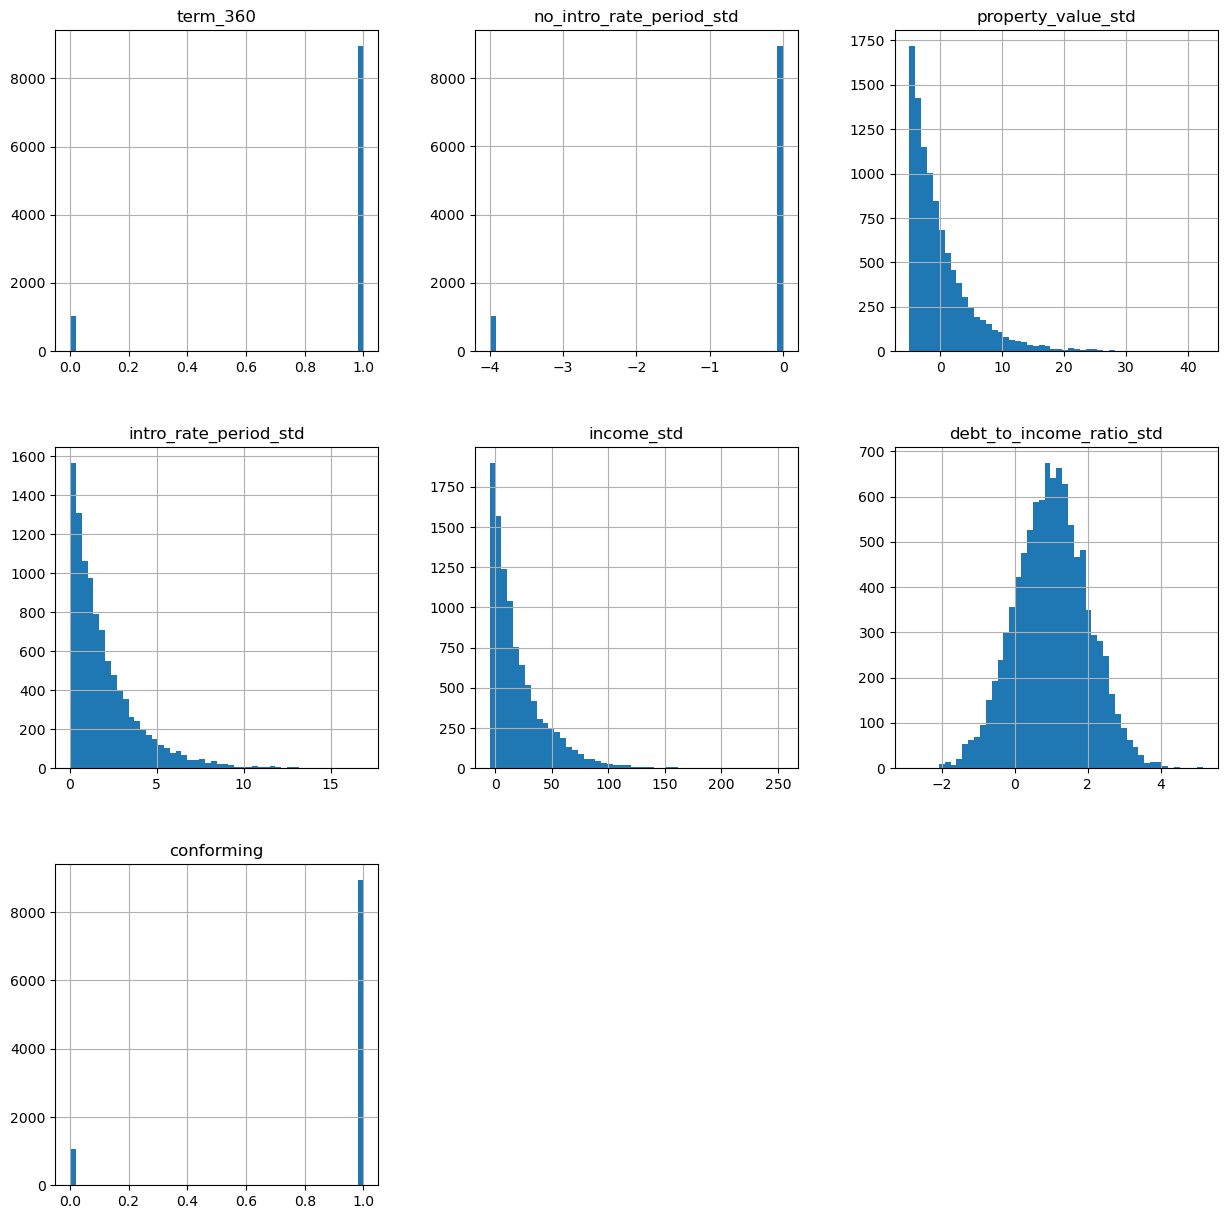

In [16]:
_ = random_frame[rem_x_names].hist(bins=50, figsize=(15, 15))

### First call to blackbox model for predictions on random data

In [17]:
blackbox_phat = pd.DataFrame(rem_xgb.predict_proba(random_frame[rem_x_names])[:, 1], columns=['phat']) 
blackbox_phat = pd.concat([random_frame.reset_index(drop=True), blackbox_phat], axis=1)
blackbox_phat.head()

,term_360,conforming,no_intro_rate_period_std,loan_amount_std,intro_rate_period_std,property_value_std,income_std,debt_to_income_ratio_std,phat
0,0,1,0,7.848707,2.018107,4.448038,7.560986,2.346077,0.058116
1,1,1,-4,49.480298,1.029955,4.580346,-1.530707,0.239296,0.113350
2,1,1,0,0.014153,2.853882,8.899881,13.705550,0.639075,0.017913
3,1,1,0,7.912400,0.248822,8.887287,1.895881,0.087230,0.025692
4,1,1,0,-4.538403,1.796115,-2.252657,27.529353,1.263036,0.169652


### Extract a stolen decision tree model

In [18]:
stolen_dt = get_cv_dt(list(schema_dict.keys()),
                      'phat',
                      blackbox_phat,
                      'stolen_dt', 
                      SEED, 
                      'Stolen Model')

Generated MOJO path:
 /Users/joonkyuhong/Desktop/GWU/python/RML/stolen_dt.zip
Discovered H2O jar path:
 /Users/anaconda3/lib/python3.10/site-packages/h2o/backend/bin/h2o.jar

Calling external process ...
java -cp /Users/anaconda3/lib/python3.10/site-packages/h2o/backend/bin/h2o.jar hex.genmodel.tools.PrintMojo --tree 0 -i /Users/joonkyuhong/Desktop/GWU/python/RML/stolen_dt.zip -o stolen_dt.gv --title "Stolen Model"
PNG file '/Users/joonkyuhong/Desktop/GWU/python/RMLstolen_dt.png' generated successfully.


### View stolen model
 - Double clicking should zoom.

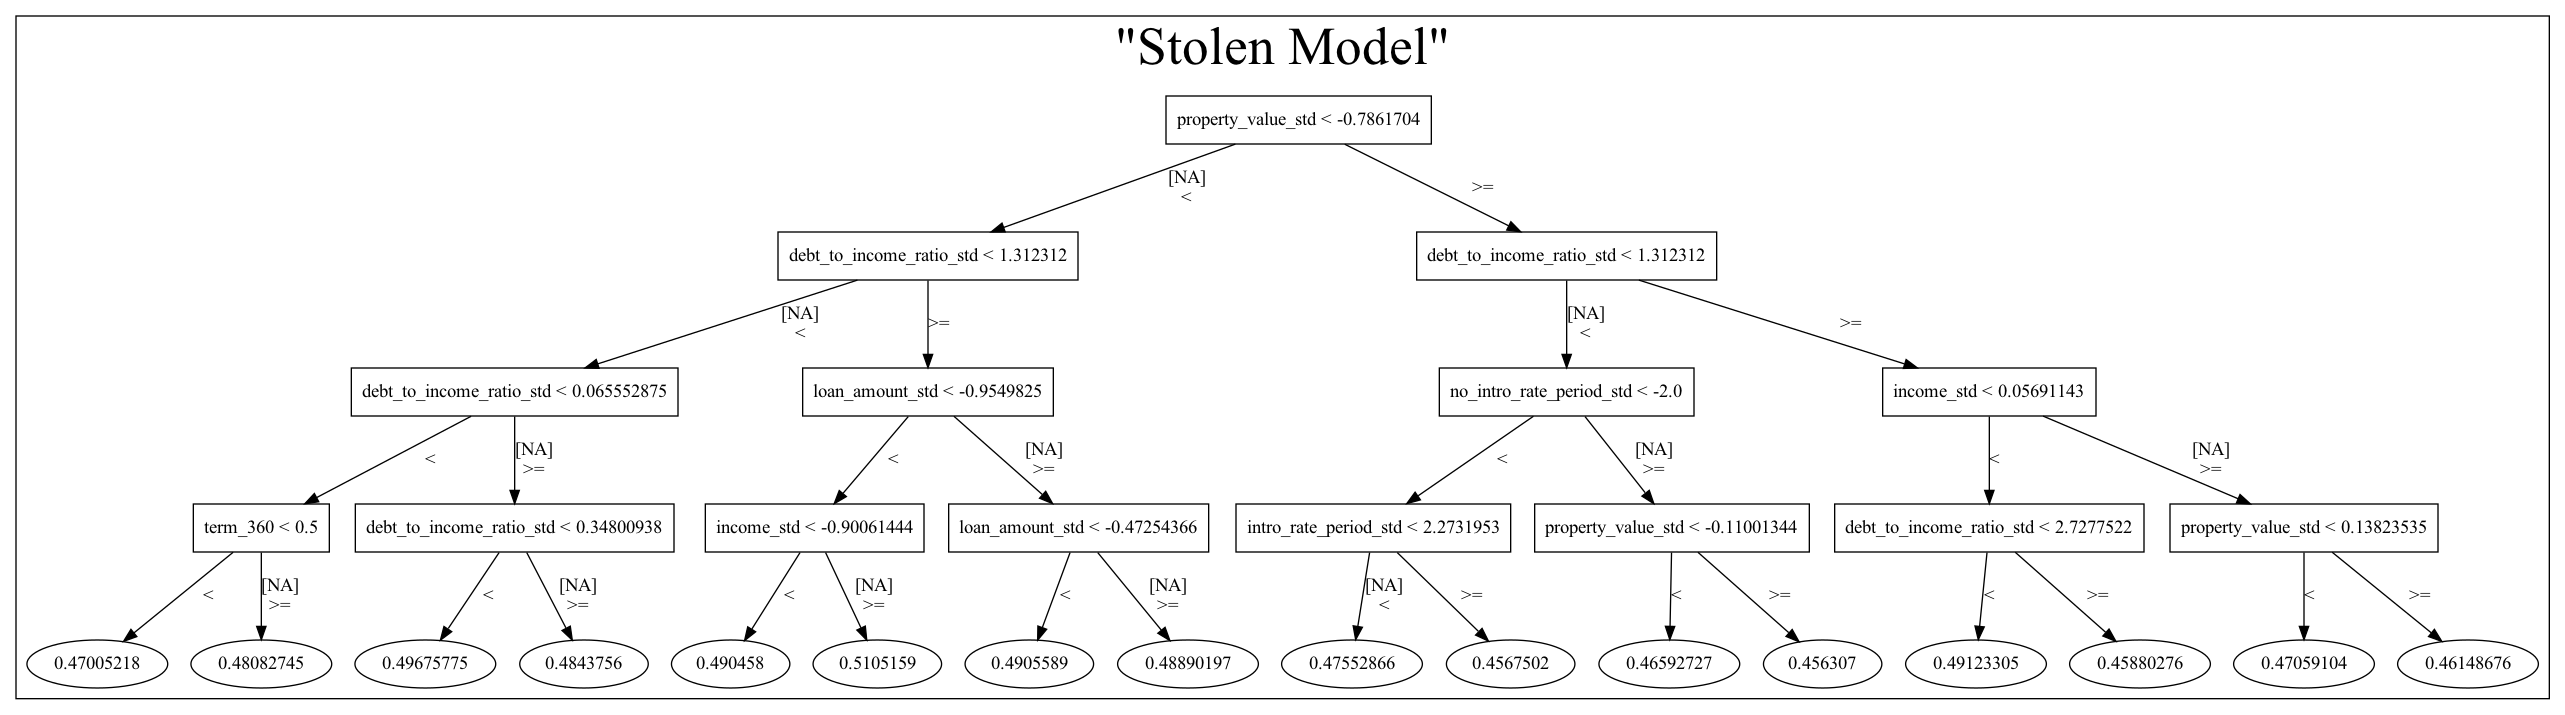

In [19]:
display(Image(('stolen_dt.png')))

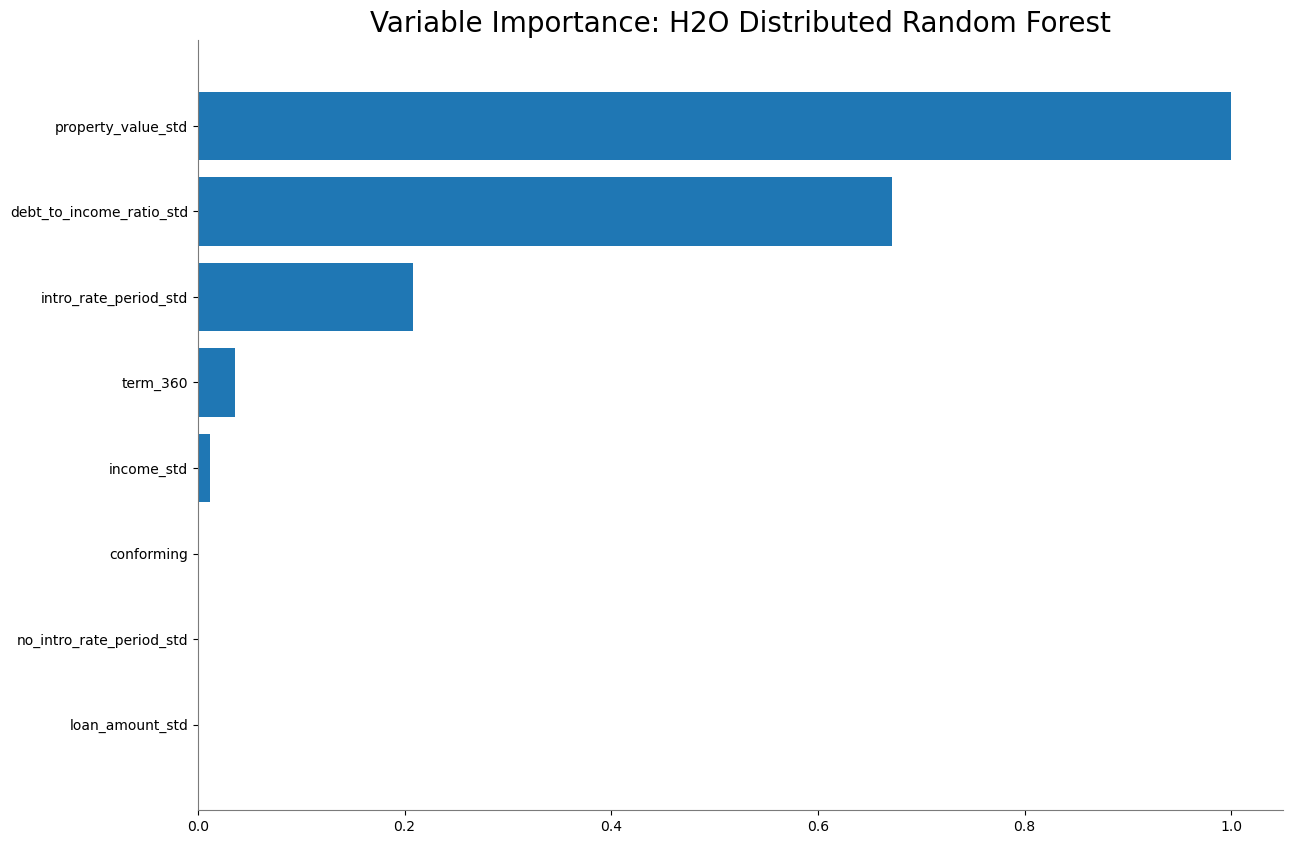

<Figure size 640x480 with 0 Axes>

In [20]:
#Variable importance for stolen model

stolen_dt.varimp_plot()

### Assess accuracy of stolen model

In [21]:
stolen_dt.cross_validation_metrics_summary() # h2o makes cv evaluation metrics available

,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid
mae,0.0310195,0.0004562,0.0310312,0.0305575,0.0314697
mean_residual_deviance,0.0019634,0.0000716,0.0020377,0.0018950,0.0019577
mse,0.0019634,0.0000716,0.0020377,0.0018950,0.0019577
r2,0.8422683,0.0067484,0.8345853,0.8449836,0.8472361
residual_deviance,0.0019634,0.0000716,0.0020377,0.0018950,0.0019577
rmse,0.0443059,0.0008066,0.0451410,0.0435312,0.0442455
rmsle,0.0370219,0.0007126,0.0377719,0.0363537,0.0369400


## Use Stolen Model to Craft Adversarial Examples
### Use stolen model to find seed rows for adversary searche

In [22]:
low_adversary_seed = random_frame.loc[(random_frame['property_value_std'] >= -0.058) &
                                      (random_frame['debt_to_income_ratio_std'] < 1.308) & 
                                      (random_frame['intro_rate_period_std'] >= 2.375), :].mean()
print('Low adversarial example search seed row:')
print(low_adversary_seed)
print()

high_adversary_seed = random_frame.loc[(random_frame['property_value_std'] < -0.647) & 
                                       (random_frame['intro_rate_period_std'] < 2.28) & 
                                       (random_frame['debt_to_income_ratio_std'] >= 1.3) & 
                                       (random_frame['term_360'] >= 0.5), :].mean()
print('High adversarial example search seed row:')
print(high_adversary_seed)

Low adversarial example search seed row:
term_360                     0.907483
conforming                   0.895238
no_intro_rate_period_std    -0.451701
loan_amount_std              4.783837
intro_rate_period_std        4.258209
property_value_std           5.130546
income_std                  19.885581
debt_to_income_ratio_std     0.371789
dtype: float64

High adversarial example search seed row:
term_360                     1.000000
conforming                   0.889458
no_intro_rate_period_std    -0.412884
loan_amount_std              5.247810
intro_rate_period_std        0.924390
property_value_std          -3.060196
income_std                  19.735920
debt_to_income_ratio_std     1.995180
dtype: float64


### Perturb seed row to find low scoring adversarial examples

In [23]:
# init results frames
low_adversary_frame = pd.DataFrame(columns=list(schema_dict.keys())) 

# quantiles over which to search 
low_quantiles = [0.01, 0.05, 0.1, 0.25, 0.5] 
high_quantiles = [0.99, 0.95, 0.9, 0.75, 0.5]

# generate potential adversarial examples across four important features
# using values of each feature and seeded by information from stolen tree
for a in list(random_frame['property_value_std'].quantile(high_quantiles)): 
        for b in list(random_frame['intro_rate_period_std'].quantile(high_quantiles)):
            for c in list(random_frame['debt_to_income_ratio_std'].quantile(low_quantiles)):
                for d in list(random_frame['term_360'].quantile(low_quantiles)):
                    low_adversary_seed['property_value_std'] = a
                    low_adversary_seed['intro_rate_period_std'] = b
                    low_adversary_seed['debt_to_income_ratio_std'] = c
                    low_adversary_seed['term_360'] = d
                    low_adversary_frame = low_adversary_frame.append(low_adversary_seed, 
                                                                     ignore_index=True, sort=False)
                    
# view potential low scoring adversarial examples
low_adversary_frame.head()

,term_360,conforming,no_intro_rate_period_std,loan_amount_std,intro_rate_period_std,property_value_std,income_std,debt_to_income_ratio_std
0,0.0,0.895238,-0.451701,4.783837,9.06958,18.545693,19.885581,-1.29433
1,0.0,0.895238,-0.451701,4.783837,9.06958,18.545693,19.885581,-1.29433
2,0.0,0.895238,-0.451701,4.783837,9.06958,18.545693,19.885581,-1.29433
3,1.0,0.895238,-0.451701,4.783837,9.06958,18.545693,19.885581,-1.29433
4,1.0,0.895238,-0.451701,4.783837,9.06958,18.545693,19.885581,-1.29433


### Perturb seed row to find high scoring adversarial examples

In [24]:
# init results frames
high_adversary_frame = pd.DataFrame(columns=list(schema_dict.keys())) 

# generate potential adversarial examples across four important features
# using values of each feature and seeded by information from stolen tree
for a in list(random_frame['property_value_std'].quantile(low_quantiles)): 
        for b in list(random_frame['intro_rate_period_std'].quantile(low_quantiles)):
            for c in list(random_frame['debt_to_income_ratio_std'].quantile(high_quantiles)):
                for d in list(random_frame['term_360'].quantile(high_quantiles)):
                    high_adversary_seed['property_value_std'] = a
                    high_adversary_seed['intro_rate_period_std'] = b
                    high_adversary_seed['debt_to_income_ratio_std'] = c
                    high_adversary_seed['term_360'] = d
                    high_adversary_frame = high_adversary_frame.append(high_adversary_seed, 
                                                                       ignore_index=True, sort=False)
                    
# view potential high scoring adversarial examples
high_adversary_frame.head()

,term_360,conforming,no_intro_rate_period_std,loan_amount_std,intro_rate_period_std,property_value_std,income_std,debt_to_income_ratio_std
0,1.0,0.889458,-0.412884,5.24781,0.018175,-4.946902,19.73592,3.322541
1,1.0,0.889458,-0.412884,5.24781,0.018175,-4.946902,19.73592,3.322541
2,1.0,0.889458,-0.412884,5.24781,0.018175,-4.946902,19.73592,3.322541
3,1.0,0.889458,-0.412884,5.24781,0.018175,-4.946902,19.73592,3.322541
4,1.0,0.889458,-0.412884,5.24781,0.018175,-4.946902,19.73592,3.322541


### Second call to blackbox API to test adversarial examples

In [25]:
# combine potential adversaries so only one call to API is needed
adversaries = pd.concat([low_adversary_frame, high_adversary_frame], axis=0)

# score potential adversarial examples to understand their effect on generated predictions
blackbox_adversaries_phat = pd.DataFrame(rem_xgb.predict_proba(adversaries[rem_x_names])[:, 1], columns=['phat']) 
blackbox_adversaries_phat = pd.concat([adversaries.reset_index(drop=True), blackbox_adversaries_phat], axis=1)
blackbox_adversaries_phat.sort_values(by='phat')

,term_360,conforming,no_intro_rate_period_std,loan_amount_std,intro_rate_period_std,property_value_std,income_std,debt_to_income_ratio_std,phat
136,0.0,0.895238,-0.451701,4.783837,9.069580,10.011155,19.885581,-0.259271,0.006080
35,0.0,0.895238,-0.451701,4.783837,6.053382,18.545693,19.885581,-0.259271,0.006080
36,0.0,0.895238,-0.451701,4.783837,6.053382,18.545693,19.885581,-0.259271,0.006080
37,0.0,0.895238,-0.451701,4.783837,6.053382,18.545693,19.885581,-0.259271,0.006080
260,0.0,0.895238,-0.451701,4.783837,9.069580,6.584122,19.885581,-0.259271,0.006080
...,...,...,...,...,...,...,...,...,...
1011,1.0,0.889458,-0.412884,5.247810,0.018175,-3.549113,19.735920,2.325711,0.382497
1012,1.0,0.889458,-0.412884,5.247810,0.018175,-3.549113,19.735920,2.325711,0.382497
1013,1.0,0.889458,-0.412884,5.247810,0.018175,-3.549113,19.735920,2.325711,0.382497
1015,1.0,0.889458,-0.412884,5.247810,0.018175,-3.549113,19.735920,1.686577,0.382497


In [26]:
toc = time.time() - tic
print('All tasks completed in %.2f s.' % (toc))

All tasks completed in 10.92 s.


In [27]:
# be careful, this can erase your work!
h2o.cluster().shutdown(prompt=True)

Are you sure you want to shutdown the H2O instance running at http://localhost:54321 (Y/N)? y
H2O session _sid_becd closed.
